## Opponent elasticity analysis in college basketball

In [1]:
import pandas as pd
import numpy as np

import random
random.seed(11)

import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import statsmodels.formula.api as smf

### Set up data

Input raw game data

In [2]:
game_stats = pd.read_csv('../../data/game_stats.csv').sort_values(['season','team','date'])
game_stats['date'] = pd.to_datetime(game_stats['date'])

Adjust offensive efficiency for home-court advantage

In [3]:
hca_adjustments = {
    'H': 0.986,
    'N': 1, 
    'A': 1.014
}

In [4]:
game_stats['hca_adj'] = game_stats['location'].map(hca_adjustments)

game_stats['o_ppp_raw'] = game_stats['o_ppp']
game_stats['o_ppp'] = game_stats['o_ppp_raw']*game_stats['hca_adj']

Calculate average adjusted offensive efficiency *in all other games besides the current one*

(note this is game-weighted when it would ideally be possession-weighted, but that will be a trivial difference here) 

In [5]:
game_stats['sum_adj_o'] = game_stats.groupby(['season','team'])['adj_o'].transform('sum')
game_stats['count_adj_o'] = game_stats.groupby(['season','team'])['adj_o'].transform('count')
game_stats['avg_adj_o'] = (game_stats['sum_adj_o']-game_stats['adj_o']) / (game_stats['count_adj_o']-1)

Calculate average opponent adjusted defensive efficiency _in all other games besides the current one_

In [6]:
reversed_game_stats = game_stats[['team','opp','date','adj_d']].rename(columns={'team':'opp','opp':'team','adj_d':'opp_adj_d'})
final_game_stats = game_stats.merge(reversed_game_stats, on=['team','opp','date'], how='left')

assert len(final_game_stats[pd.isnull(final_game_stats['opp_adj_d'])])==0 # no missing matches

In [7]:
final_game_stats['sum_opp_adj_d'] = final_game_stats.groupby(['season','opp'])['opp_adj_d'].transform('sum')
final_game_stats['count_opp_games'] = final_game_stats.groupby(['season','opp'])['date'].transform('count')
final_game_stats['avg_opp_adj_d'] = (final_game_stats['sum_opp_adj_d'] - final_game_stats['opp_adj_d']) / (final_game_stats['count_opp_games'] - 1)

Clean up df

In [8]:
final_game_stats = final_game_stats[['date','season','team','opp','location','o_ppp','avg_adj_o','avg_opp_adj_d']]

sense-check: make sure offensive efficiency is higher against worse defenses

(even though there is a selection effect here - better teams usually play better opponents)

correlation:  0.2611778879885799


<AxesSubplot:xlabel='avg_opp_adj_d', ylabel='o_ppp'>

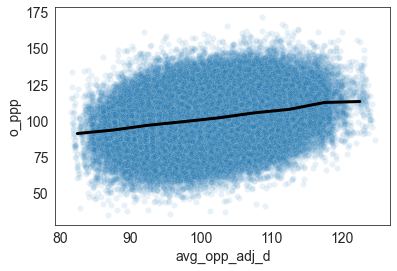

In [9]:
print("correlation: ", final_game_stats[['o_ppp','avg_opp_adj_d']].corr().iloc[0,1])

# also show a line with binned averages
bins = [0] + list(range(85, 135, 5)) 
lbls = [b-2.5 for b in bins[1:]]
final_game_stats['avg_opp_adj_d_bin'] = pd.cut(final_game_stats['avg_opp_adj_d'], bins=bins, labels=lbls)
summary = final_game_stats.groupby(['avg_opp_adj_d_bin'])['o_ppp'].mean().reset_index()

sns.scatterplot(x='avg_opp_adj_d', y='o_ppp', data=final_game_stats, alpha=0.1)
sns.lineplot(x='avg_opp_adj_d_bin', y='o_ppp', data=summary, color='black', lw=3)

### Measuring opponent elasticities

What we really want to know is, *for an individual team*, how does offensive efficiency vary with opponent defense strength?

Measure this with the 'beta' (regression slope):

In [10]:
unique_team_seasons = final_game_stats.groupby(['season','team']).date.count().reset_index()
unique_team_seasons.columns=['season','team','num_games']

unique_team_seasons = unique_team_seasons[unique_team_seasons.num_games>=20].drop('num_games', axis=1)
    # remove the very-shortened seasons (mostly Covid-related)

betas = []
for season, team in unique_team_seasons.values:
    corr = final_game_stats[(final_game_stats.season==season)&(final_game_stats.team==team)][['o_ppp','avg_opp_adj_d']].corr().iloc[0,1]
    x_std = final_game_stats[(final_game_stats.season==season)&(final_game_stats.team==team)]['avg_opp_adj_d'].std()
    y_std = final_game_stats[(final_game_stats.season==season)&(final_game_stats.team==team)]['o_ppp'].std()
    beta = corr * y_std / x_std
    betas.append(beta)

unique_team_seasons['beta'] = betas
unique_team_seasons

,season,team,beta
0,2008,Air Force,0.860031
1,2008,Akron,1.384113
2,2008,Alabama,1.289896
3,2008,Alabama A&M,1.539639
4,2008,Alabama St.,0.944730
...,...,...,...
5229,2022,Wright St.,1.431964
5230,2022,Wyoming,1.005399
5231,2022,Xavier,0.535000
5232,2022,Yale,1.717324


median beta: 0.951651000531947


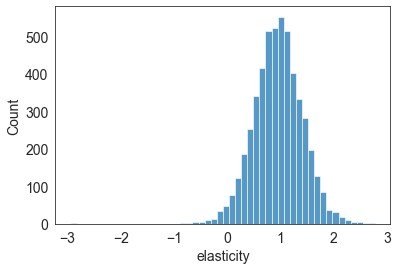

In [11]:
print("median beta:", unique_team_seasons['beta'].median())
sns.histplot(unique_team_seasons['beta'], bins=50).set_xlabel('elasticity')
plt.show()

As expected, the median elasticity is ~1

However, there's a lot of variation!

In [12]:
print("% below 0:", 100*len(unique_team_seasons[unique_team_seasons['beta']<0])/len(unique_team_seasons))
print("% below 0.5:", 100*len(unique_team_seasons[unique_team_seasons['beta']<0.5])/len(unique_team_seasons))
print("% above 1.5:", 100*len(unique_team_seasons[unique_team_seasons['beta']>1.5])/len(unique_team_seasons))
print("% above 2:", 100*len(unique_team_seasons[unique_team_seasons['beta']>2])/len(unique_team_seasons))

% below 0: 2.000388424936881
% below 0.5: 15.226257525733152
% above 1.5: 10.720528257914157
% above 2: 1.1458535637987959


2022 Radford 2.551389451169514


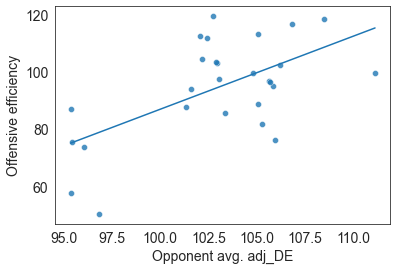

In [13]:
# example: team with highest elasticity in 2022
max_beta = unique_team_seasons[unique_team_seasons.season==2022].beta.max()
max_beta_team = unique_team_seasons[(unique_team_seasons.beta==max_beta)&(unique_team_seasons.season==2022)].to_dict(orient='records')[0]
print(max_beta_team['season'], max_beta_team['team'], max_beta_team['beta'])

team_games = final_game_stats[(final_game_stats.season==max_beta_team['season'])&(final_game_stats.team==max_beta_team['team'])]

sns.scatterplot(x='avg_opp_adj_d', y='o_ppp', data=team_games, alpha=0.8)

alpha = team_games.o_ppp.mean() - team_games.avg_opp_adj_d.mean()*max_beta 
x_line = [team_games.avg_opp_adj_d.min(), team_games.avg_opp_adj_d.max()]
y_line = [alpha + max_beta*i for i in x_line]
sns.lineplot(x=x_line, y=y_line)
plt.xlabel("Opponent avg. adj_DE")
plt.ylabel("Offensive efficiency")
plt.show()

2022 Little Rock -0.6007194331346069


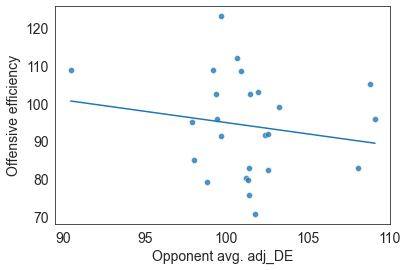

In [14]:
# example: team with lowest beta in 2022
min_beta = unique_team_seasons[unique_team_seasons.season==2022].beta.min()
min_beta_team = unique_team_seasons[(unique_team_seasons.beta==min_beta)&(unique_team_seasons.season==2022)].to_dict(orient='records')[0]
print(min_beta_team['season'], min_beta_team['team'], min_beta_team['beta'])

team_games = final_game_stats[(final_game_stats.season==min_beta_team['season'])&(final_game_stats.team==min_beta_team['team'])]

sns.scatterplot(x='avg_opp_adj_d', y='o_ppp', data=team_games, alpha=0.8)

alpha = team_games.o_ppp.mean() - team_games.avg_opp_adj_d.mean()*min_beta 
x_line = [team_games.avg_opp_adj_d.min(), team_games.avg_opp_adj_d.max()]
y_line = [alpha + min_beta*i for i in x_line]
sns.lineplot(x=x_line, y=y_line)
plt.xlabel("Opponent avg. adj_DE")
plt.ylabel("Offensive efficiency")
plt.show()

In [15]:
# highest and lowest betas
unique_team_seasons[unique_team_seasons.season==2022].sort_values('beta', ascending=False).head(10)

,season,team,beta
5116,2022,Radford,2.551389
4898,2022,Belmont,2.442864
4996,2022,Idaho St.,2.264225
4880,2022,Alabama A&M,2.063736
5144,2022,South Dakota,2.061320
4997,2022,Illinois,2.043354
4971,2022,Furman,2.019954
5203,2022,Utah,1.996385
4959,2022,Evansville,1.986886
4969,2022,Fort Wayne,1.984917


In [16]:
unique_team_seasons[unique_team_seasons.season==2022].sort_values('beta').head(10)

,season,team,beta
5023,2022,Little Rock,-0.600719
4993,2022,Howard,-0.500324
4955,2022,Eastern Kentucky,-0.179988
5107,2022,Pittsburgh,-0.155504
4934,2022,Columbia,-0.113480
5225,2022,William & Mary,-0.112850
4922,2022,Charleston Southern,-0.104604
5051,2022,Minnesota,-0.096647
4943,2022,Delaware,-0.051158
5146,2022,South Florida,-0.048095


### Assessing reliability

CBB seasons are small samples, however, so is this just noise? 

To better understand the reliability of this metric, we're going to use *split-half correlation*
- split each team's season into odd-numbered and even-numbered games 
    - (better to do it this way than first-half vs second-half because e.g. power-conference schedules will be backloaded with most of their strong opponents)
- in each half, measure the correlation between offensive efficiency and defensive strength
- meausre the correlation between the two correlations (odd vs even games)
    - if this metric is just noise, there will be no correlation between the halves
    - but if there's meaning in it, some teams will consistently be more (less) correlated than average in each half, and there will be a visible positive correlation

In [17]:
# split halves

final_game_stats.sort_values(['season','team','date'], inplace=True)

final_game_stats['game_in_season'] = final_game_stats.groupby(['season','team'])['date'].transform('cumcount')
final_game_stats['half'] = 1 + final_game_stats['game_in_season'] % 2 
final_game_stats.head()

,date,season,team,opp,location,o_ppp,avg_adj_o,avg_opp_adj_d,avg_opp_adj_d_bin,game_in_season,half
12,2007-11-09,2008,Air Force,Dartmouth,H,109.9390,98.718519,107.748000,107.5,0,1
6,2007-11-10,2008,Air Force,Northern Colorado,H,112.0096,98.492593,103.657692,102.5,1,2
7,2007-11-19,2008,Air Force,Radford,H,82.4296,99.662963,111.018519,112.5,2,1
8,2007-11-23,2008,Air Force,Mississippi Valley St.,N,97.7000,99.044444,105.410000,107.5,3,2
9,2007-11-24,2008,Air Force,Montana,N,96.8000,99.144444,108.229630,107.5,4,1


In [18]:
# measure beta in each half
# note we already filtered unique_team_seasons for 20+ games above

betas_1 = []
betas_2 = []
for season, team in unique_team_seasons[['season','team']].values:
    corr_1 = final_game_stats[((final_game_stats.season==season)&(final_game_stats.team==team))&(final_game_stats.half==1)][['o_ppp','avg_opp_adj_d']].corr().iloc[0,1]
    x_std_1 = final_game_stats[((final_game_stats.season==season)&(final_game_stats.team==team))&(final_game_stats.half==1)]['avg_opp_adj_d'].std()
    y_std_1 = final_game_stats[((final_game_stats.season==season)&(final_game_stats.team==team))&(final_game_stats.half==1)]['o_ppp'].std()
    beta_1 = corr_1 * y_std_1 / x_std_1

    corr_2 = final_game_stats[((final_game_stats.season==season)&(final_game_stats.team==team))&(final_game_stats.half==2)][['o_ppp','avg_opp_adj_d']].corr().iloc[0,1]
    x_std_2 = final_game_stats[((final_game_stats.season==season)&(final_game_stats.team==team))&(final_game_stats.half==2)]['avg_opp_adj_d'].std()
    y_std_2 = final_game_stats[((final_game_stats.season==season)&(final_game_stats.team==team))&(final_game_stats.half==2)]['o_ppp'].std()
    beta_2 = corr_2 * y_std_2 / x_std_2

    betas_1.append(beta_1)
    betas_2.append(beta_2)

unique_team_seasons['beta_1'] = betas_1
unique_team_seasons['beta_2'] = betas_2

correl: 0.04917447569653684
rsq: 0.002418129060029292


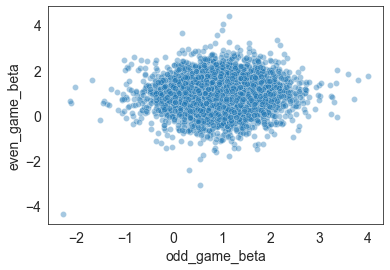

In [19]:
# measure reliability between halves

print("correl:", unique_team_seasons[['beta_1','beta_2']].corr().iloc[0,1])
print("rsq:", unique_team_seasons[['beta_1','beta_2']].corr().iloc[0,1]**2)

sns.scatterplot(x='beta_1', y='beta_2', data=unique_team_seasons, alpha=0.4
    )
plt.xlabel('odd_game_beta')
plt.ylabel('even_game_beta')
plt.show()

That's underwhelming...

Could we get a correlation that strong from random data?
- We'll do a fake-data simulation: shuffle all the observed half-season-betas randomly, split them into two groups and find correlation

max correlation: 0.0421376677067718


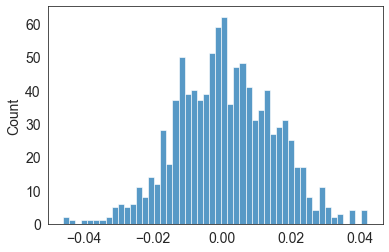

In [20]:
# fake-data simulation to see how likely that correlation is to come by chance from these values

n_sims = 1000
all_observed_corrs = unique_team_seasons['beta_1'].values.tolist() + unique_team_seasons['beta_2'].values.tolist()

sim_correls = []
for i in range(n_sims): 
    data = all_observed_corrs.copy()
    random.shuffle(data)

    data_1 = data[0:len(all_observed_corrs)-1:2]
    data_2 = data[1:len(all_observed_corrs):2]

    sim_correls.append(np.corrcoef(data_1, data_2)[0,1])

sns.histplot(sim_correls, bins=50)
print("max correlation:", max(sim_correls))

Even in 1000 sims we never get a correlation with random data as strong as the one we found

So there's *some* real pattern here

But is it practically significant? 
- If we have an extreme first half of the season (say a 0 elasticity), what's the projected "true" elasticity for the second half? 

In [21]:
# run regression to predict opposite-half beta from the other 

x_bar = unique_team_seasons['beta_1'].mean()
y_bar = unique_team_seasons['beta_2'].mean()

x_std = unique_team_seasons['beta_1'].std()
y_std = unique_team_seasons['beta_2'].std()

corr = unique_team_seasons['beta_1'].corr(unique_team_seasons['beta_2'])

beta = corr * y_std / x_std
alpha = y_bar - beta*x_bar

In [22]:
alpha, beta

(0.8838366637883723, 0.05226829873086907)

C:\Users\whita\miniconda3\envs\cbb\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


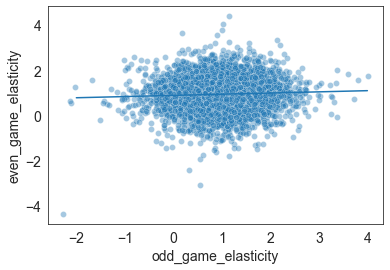

In [24]:
x_range = np.arange(-2,5,1)
y_range = beta*x_range + alpha

sns.scatterplot(x='beta_1', y='beta_2', data=unique_team_seasons, alpha=0.4)
sns.lineplot(x_range, y_range)

plt.xlabel('odd_game_elasticity')
plt.ylabel('even_game_elasticity')
plt.show()

In [25]:
# what is the impact if you have a 0.0 beta halfway through the season?
# 0.0 beta is pretty extreme even in half a season (6th percentile)

print("mean elasticity for all teams:", alpha + beta*x_bar)
print("predicted elasticity for a team with 0.0 first-half elasticity:", alpha + beta*0.0)

mean elasticity for all teams: 0.9337938364674542
predicted elasticity for a team with 0.0 first-half elasticity: 0.8838366637883723


...so that's not very meaningful

### Predictors

Out of curiosity, even if it isn't very important, what's correlated with elasticity?

In [26]:
# four factors stats
team_stats = pd.read_csv('../../data/team_stats.csv').rename(columns={'TeamName':'team'}).sort_values(['season','team'])

# two-point shooting breakout
pbp_stats = pd.read_csv('../../data/pbp_stats.csv').sort_values(['season','team'])

# overall adjusted efficiency
eff_stats = pd.read_csv('../../data/team_efficiency.csv').sort_values(['season','team'])

team_stats = team_stats.merge(pbp_stats, on=['season','team'], how='left').merge(eff_stats, on=['season','team'], how='left')

In [27]:
# select non-rank columns and standardize within each year

team_stats_reg = team_stats[[c for c in team_stats.columns if '_rk' not in c]].copy()

for c in team_stats_reg.columns:
    if c not in ['season','team']:
        team_stats_reg[c] = (team_stats_reg[c] - team_stats_reg.groupby('season')[c].transform('mean')) / team_stats_reg.groupby('season')[c].transform('std')

In [28]:
unique_team_seasons = unique_team_seasons.merge(team_stats_reg, on=['season','team'], how='left')

In [29]:
# clean column headers so they can go into regression
unique_team_seasons.columns = [c.replace('%','_pct') for c in unique_team_seasons.columns]
unique_team_seasons.columns = [c.replace(' ','') for c in unique_team_seasons.columns]
unique_team_seasons.columns = [c.replace('.','') for c in unique_team_seasons.columns]
unique_team_seasons.columns = [c.replace('3','three') for c in unique_team_seasons.columns]
unique_team_seasons.columns = [c.replace('2','two') for c in unique_team_seasons.columns]

factor_cols = ['adjoe', 
        'eFG_pct', 'OR_pct', 'TO_pct', 'FTR', 
        'closetwo_pct', 'longtwo_pct', 'threeP_pct',
        'closetwo_share', 'longtwo_share', 'threePrate',
        'blockrateO', 'ft_pct', 'arate' 
        ] # remove defensive stats

In [30]:
# run univariate regressions with each predictor just to see if there's any relationship

factor_corrs = []
for c in factor_cols: 
    results = smf.ols(f'beta ~ {c}', data=unique_team_seasons).fit()
    factor_corrs.append([c, results.params[1], results.pvalues[1]])

pd.DataFrame(factor_corrs, columns=['factor','beta','pvalue']).sort_values('beta', ascending=False)

,factor,beta,pvalue
8,closetwo_share,0.015101,0.026318
7,threeP_pct,0.012503,0.048783
3,TO_pct,0.010230,0.105790
11,blockrateO,0.006624,0.295192
1,eFG_pct,0.005159,0.415692
12,ft_pct,0.002962,0.640091
13,arate,0.000448,0.943796
5,closetwo_pct,-0.000649,0.923800
10,threePrate,-0.005250,0.406461
2,OR_pct,-0.005254,0.407336


In [31]:
# run multivariate regression, focusing only on "style" metrics (not "how good you are" which is a bit endogeneous here)
# with adjoe as control

style_cols = ['closetwo_share','longtwo_share','threePrate','arate','FTR','adjoe']
results = smf.ols(f'beta ~ ' + ' + '.join(style_cols), data=unique_team_seasons).fit()

results = pd.DataFrame(results.params[1:], columns=['beta']).merge(pd.DataFrame(results.pvalues[1:], columns=['pvalue']), left_index=True, right_index=True
    ).sort_values('beta', ascending=False)

results

,beta,pvalue
closetwo_share,0.017757,0.829680
arate,0.007854,0.281460
threePrate,0.003230,0.970709
longtwo_share,-0.002027,0.984217
FTR,-0.008994,0.220238
adjoe,-0.023486,0.000996
